(41188, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
y
no     36548
yes     4640
Name: count, dtype: int64
               age
count  41188.00000
mean      40.02406
std       10.42125
min       17.00000
25%       32.00000
50%       38.00000
75%       47.00000
max       98.00000
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
Name: count, dtype: int64
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


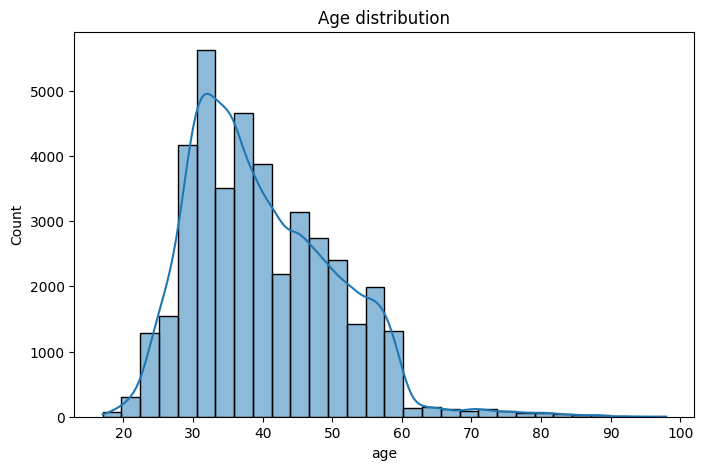

  age_group  accept_rate
0     18-25     0.208910
1     26-35     0.117195
2     36-45     0.085098
3     46-55     0.086920
4     56-65     0.152211
5       65+     0.468498


/tmp/ipython-input-1237118022.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_accept = df.groupby('age_group')['y'].apply(lambda x: (x=='yes').mean()).reset_index(name='accept_rate')


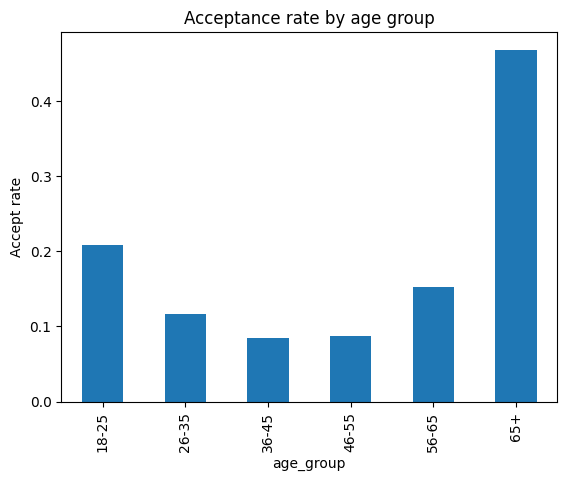

             job  accept_rate
0        student     0.314286
1        retired     0.252326
2     unemployed     0.142012
3         admin.     0.129726
4     management     0.112175
5        unknown     0.112121
6     technician     0.108260
7  self-employed     0.104856
8      housemaid     0.100000
9   entrepreneur     0.085165
    marital  accept_rate
0  divorced     0.103209
1   married     0.101573
2    single     0.140041
3   unknown     0.150000
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numeric: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
--- Logistic Regression (test) ---
Accuracy: 0.8351541636319495
Precision: 0.3679361179361179
Recall: 0.6454741379310345
F1: 0.46870109546165883
ROC AUC: 0.8009287731732628
Confusion Matrix:
 [[6281 1029]
 [ 329  599]]
              precision    recall  f1-score   support

           0       0

/tmp/ipython-input-1237118022.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_summary = seg.groupby(['age_group','job'])['accept'].agg(['count','mean']).reset_index()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report, roc_curve)

#Load data
df = pd.read_csv("/content/bank-additional-full.csv", sep=';')

print(df.shape)
print(df.columns)
print(df['y'].value_counts())   #target distribution

#Basic EDA: age, job, marital status

#Summary stats
print(df[['age']].describe())
print(df['job'].value_counts().head(10))
print(df['marital'].value_counts())

#Visualizations (age distribution+target by category)
plt.figure(figsize=(8,5))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age distribution")
plt.show()

#Target rate by age groups
df['age_group'] = pd.cut(df['age'], bins=[17,25,35,45,55,65,100],
                         labels=['18-25','26-35','36-45','46-55','56-65','65+'])
age_accept = df.groupby('age_group')['y'].apply(lambda x: (x=='yes').mean()).reset_index(name='accept_rate')
print(age_accept)
age_accept.plot.bar(x='age_group', y='accept_rate', legend=False)
plt.title("Acceptance rate by age group")
plt.ylabel("Accept rate")
plt.show()

#Job and marital
job_accept = df.groupby('job')['y'].apply(lambda x: (x=='yes').mean()).sort_values(ascending=False).reset_index(name='accept_rate')
print(job_accept.head(10))

marital_accept = df.groupby('marital')['y'].apply(lambda x: (x=='yes').mean()).reset_index(name='accept_rate')
print(marital_accept)

#Preprocessing for modeling

#Select features (drop columns not useful or leaked like "duration" if present)
drop_cols = ['duration'] if 'duration' in df.columns else []
X = df.drop(columns=['y'] + drop_cols + ['age_group'])  # keep raw age; drop derived
y = (df['y'] == 'yes').astype(int)

#Identify categorical and numeric
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

#Build preprocessing pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='drop')

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Modeling pipelines
#Logistic Regression
log_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

#Decision Tree
dt_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

#Fit models
log_pipe.fit(X_train, y_train)
dt_pipe.fit(X_train, y_train)

#Evaluation function
def evaluate(model, Xt, yt, label="Model"):
    preds = model.predict(Xt)
    probs = model.predict_proba(Xt)[:,1] if hasattr(model, "predict_proba") else None
    print(f"--- {label} ---")
    print("Accuracy:", accuracy_score(yt, preds))
    print("Precision:", precision_score(yt, preds))
    print("Recall:", recall_score(yt, preds))
    print("F1:", f1_score(yt, preds))
    if probs is not None:
        print("ROC AUC:", roc_auc_score(yt, probs))
    print("Confusion Matrix:\n", confusion_matrix(yt, preds))
    print(classification_report(yt, preds))

#Evaluate on test set
evaluate(log_pipe, X_test, y_test, "Logistic Regression (test)")
evaluate(dt_pipe, X_test, y_test, "Decision Tree (test)")

#Feature importance / coefficients
#For logistic: map coefficients back to feature names after preprocessing
ohe = log_pipe.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
feat_names = num_cols + cat_feature_names
coefs = log_pipe.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values('abs_coef', ascending=False).head(20)

#For decision tree: feature importances
dt_pre = dt_pipe.named_steps['pre']

#get transformed X columns
#Use same feat_names as above (they match the preprocessing)
importances = dt_pipe.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
imp_df.sort_values('importance', ascending=False).head(20)

#Business insights (example code)
#Which job types have highest acceptance?
top_jobs = job_accept.sort_values('accept_rate', ascending=False).head(10)
print("Top job types by accept rate:\n", top_jobs)

#Find top segments by combining features (age_group & job)
seg = df.copy()
seg['accept'] = (seg['y']=='yes').astype(int)
seg_summary = seg.groupby(['age_group','job'])['accept'].agg(['count','mean']).reset_index()

#Filter segments with at least n customers
popular_segments = seg_summary[seg_summary['count']>=50].sort_values('mean', ascending=False).head(10)
print(popular_segments)

#Save important outputs
coef_df.sort_values('abs_coef', ascending=False).to_csv("logistic_top_features.csv", index=False)
imp_df.sort_values('importance', ascending=False).to_csv("dt_top_features.csv", index=False)
